<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/3/39/VU_logo.png/800px-VU_logo.png?20161029201021" width="350">

### Programming large-scale parallel systems


# All pairs of shortest paths


## Contents

In this notebook, we will learn

- How to parallelize Floyd's algorithm
- How communication can affect the correctness of a distributed algorithm


## The All Pairs of Shortest Paths (ASP) problem

Let us start by presenting the all pairs of shortest paths (ASP) problem and its solution with the [Floyd–Warshall algorithm](https://en.wikipedia.org/wiki/Floyd%E2%80%93Warshall_algorithm).

### Problem statement

- Given a graph $G$ with a distance table $C$
- Compute the length of the shortest path between any two nodes in $G$

We represent the distance table as a matrix, where $C_{ij}$ is the distance from node $i$ to node $j$. Next figure shows the input and solution (output) of the ASP problem for a simple 4-node directed graph. Note that the minimum distance from node 2 to node 3, which is $C_{23}=8$ as highlighted in the figure.


<div>
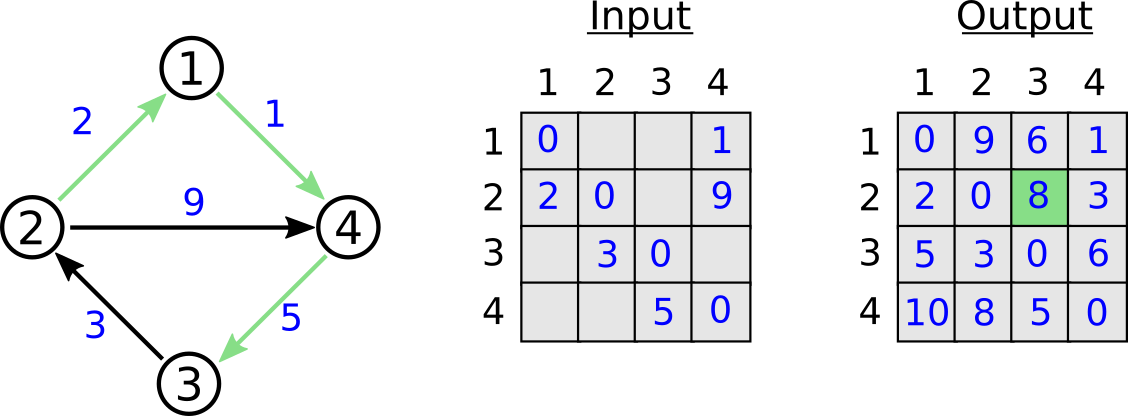
</div>
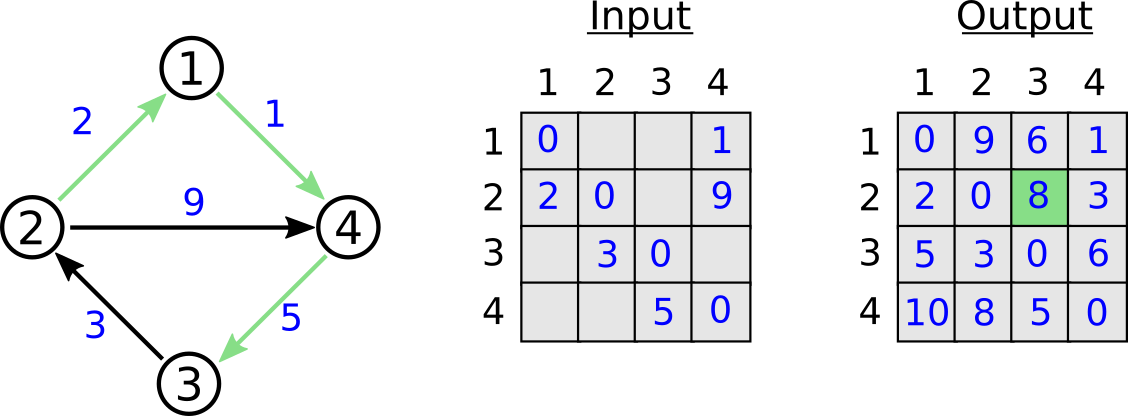

### Floyd's sequential algoritm

The ASP problem can be solved with the  [Floyd–Warshall algorithm](https://en.wikipedia.org/wiki/Floyd%E2%80%93Warshall_algorithm). A sequential implementation of this algorithm is given in the following function:

In [ ]:
function floyd!(C)
  n = size(C,1)
  @assert size(C,2) == n
  for k in 1:n
    for j in 1:n
      for i in 1:n
        @inbounds C[i,j] = min(C[i,j],C[i,k]+C[k,j])
      end
    end
  end
  C
end

You can check that this function computes the solution of the small ASP problem in the figure above by executing next cell. Note that we used a large number to represent that there is no direct connection between two nodes.

In [ ]:
inf = 1000
C = [
      0 inf inf   1
      2   0 inf   9
    inf   3   0 inf
    inf inf   5   0   
]
floyd!(C)

### The algorithm explained

The main idea of the algorithm is to perform as many iterations as nodes in the graph. At iteration $k$, we update the distance matrix $C$ by finding the shortest paths between each pair of nodes, allowing indirect paths via nodes from 1 to $k$. At the last iteration, it is allowed to visit all nodes and, thus, the distance table will contain the solution of the ASP problem.

This process is cleverly done with three nested loops:

```julia
n = size(C,1)
for k in 1:n
    for j in 1:n
        for i in 1:n
            C[i,j] = min(C[i,j],C[i,k]+C[k,j])
        end
    end
end
```

At each outer iteration $k$, we do a loop over the distance matrix $C$. For each pair of nodes  $i$ and $j$ we compare the current distance $C_{ij}$ against the distance via node $k$, namely $C_{ik}+C_{kj}$, and update  $C_{ij}$ with the minimum.

<div>
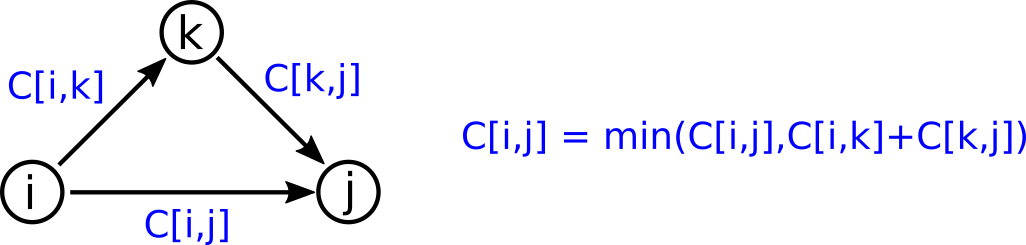
</div>

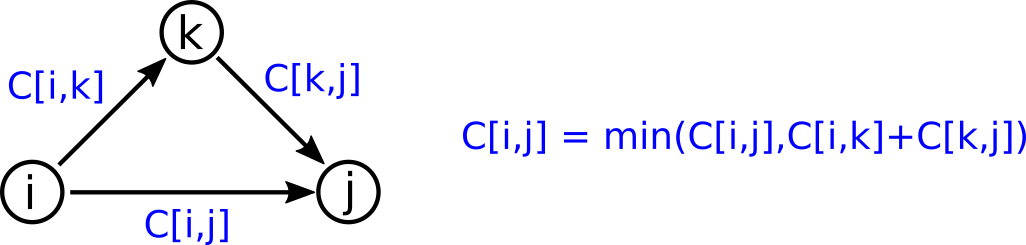

The update of the distance matrix at each iteration is illustrated in the next figure for a small ASP presented above. We highlight in green the distances that are updated in each iteration. Note that adding values to the table can be interpreted as adding new connections in the graph, as illustrated in the figure.

<div>
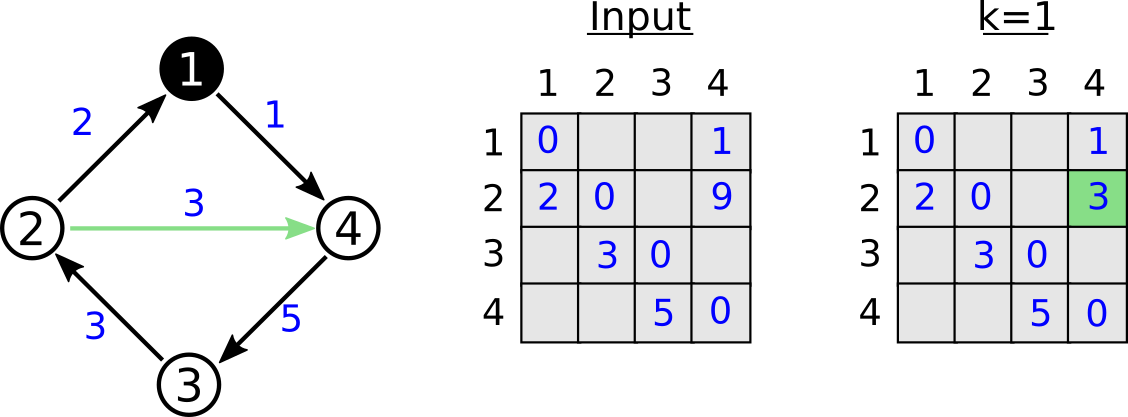
</div>
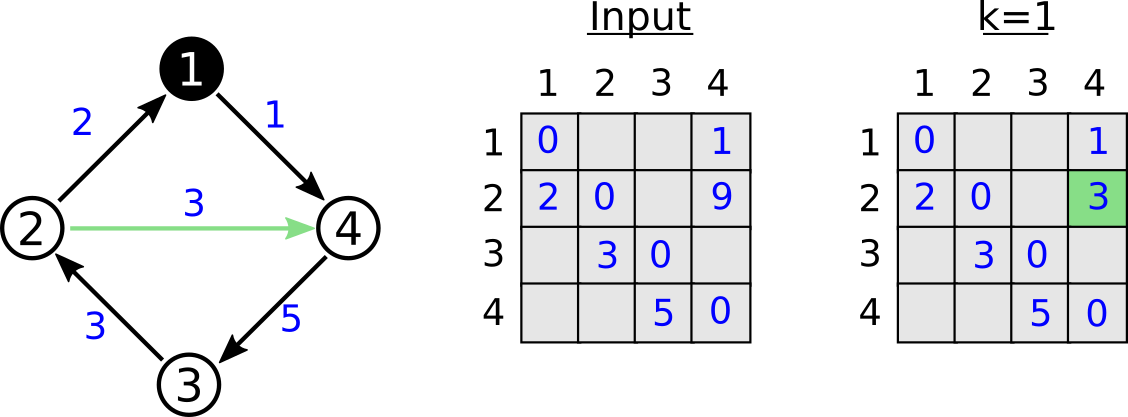

<div>
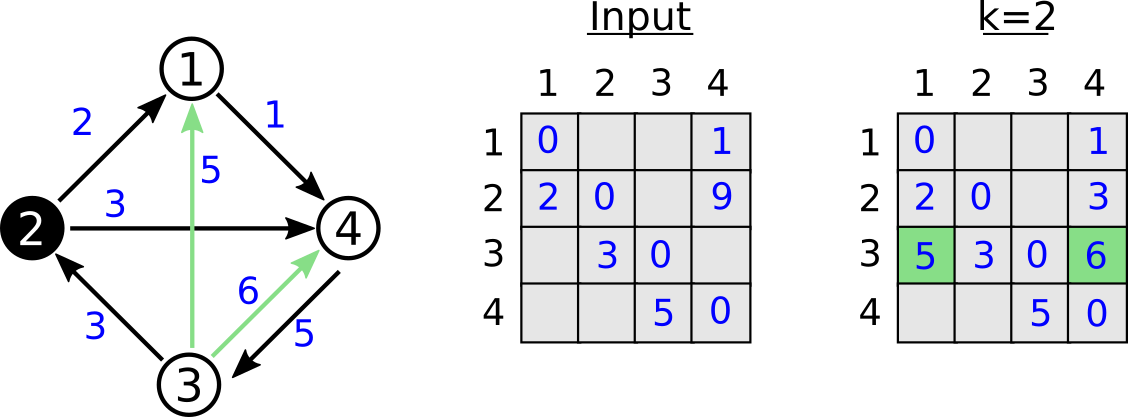
</div>
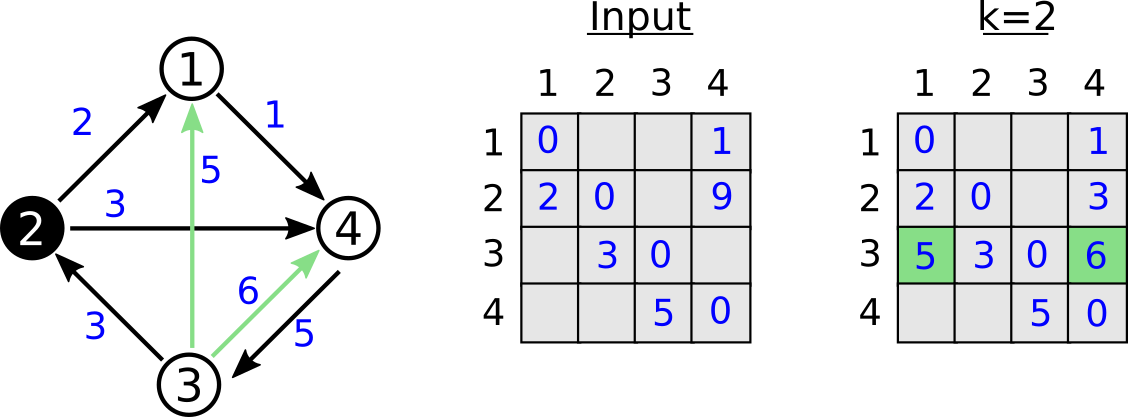

<div>
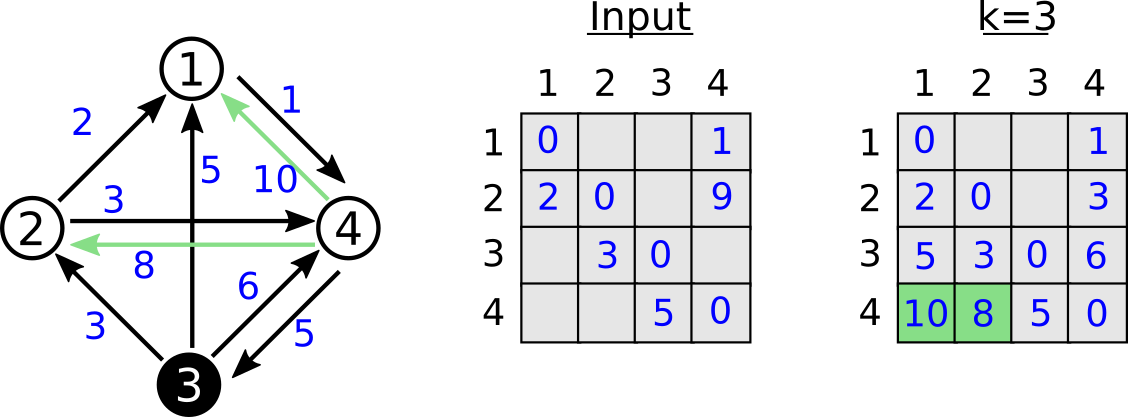
</div>
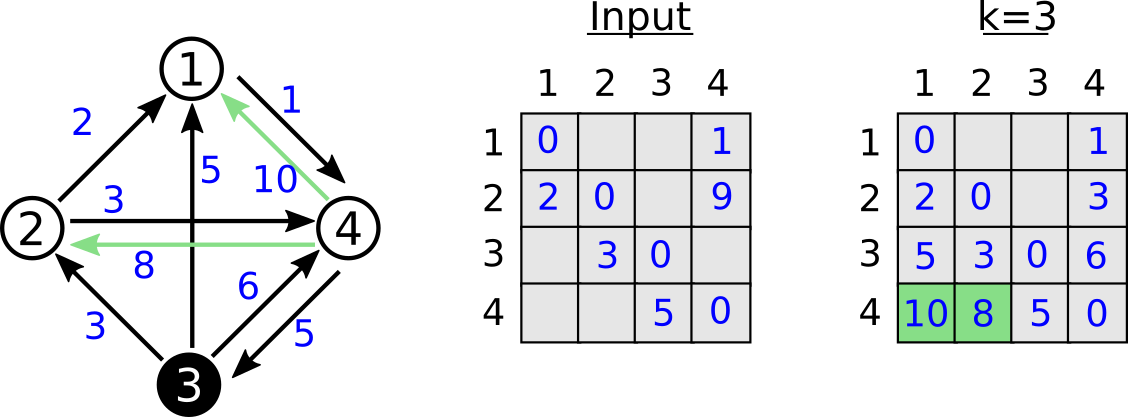

<div>
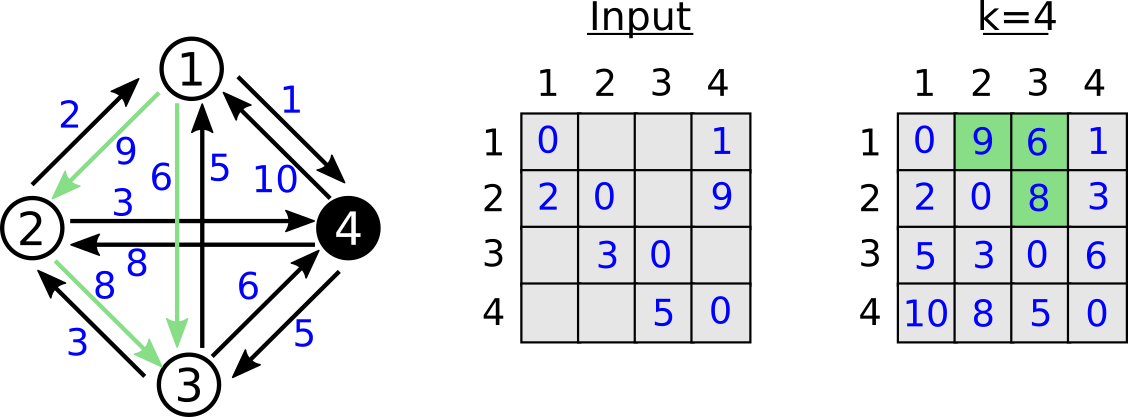
</div>
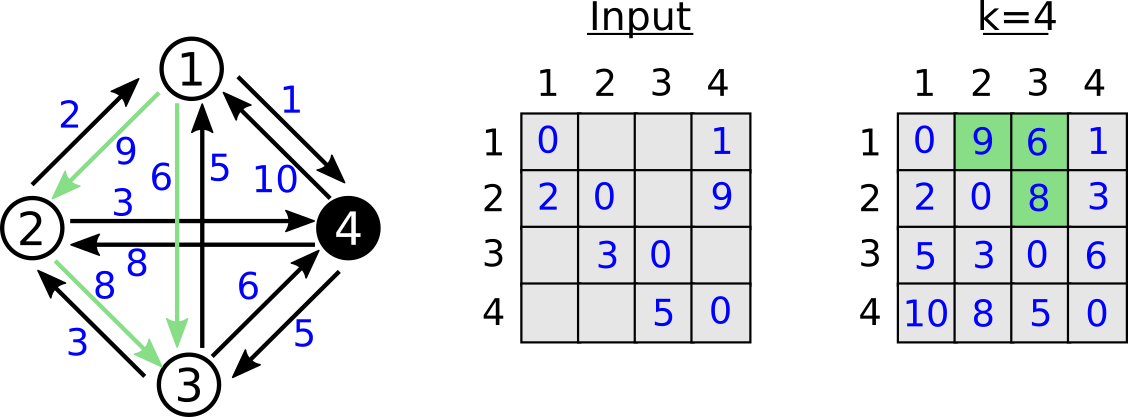

### Serial performance

This algorithm is memory bound, meaning that the main cost is in getting and setting data from the input matrix `C`. In this situations, the order in which we traverse the entries of matrix `C` has a significant performance impact.

The following function computes the same result as for the previous function `floyd!`, but the nesting of loops over i and j is changed.


In [ ]:
function floyd2!(C)
  n = size(C,1)
  @assert size(C,2) == n
  for k in 1:n
    for i in 1:n
      for j in 1:n
        @inbounds C[i,j] = min(C[i,j],C[i,k]+C[k,j])
      end
    end
  end
  C
end

 Compare the performance of both implementations (run the cell several times).

In [ ]:
n = 1000
C = rand(n,n)
@time floyd!(C)
C = rand(n,n)
@time floyd2!(C);

The performance difference is significant. Matrices in Julia are stored in memory in column-major order (like in Fortran, unlike in C). It means that it is more efficient to access the data also in column-major order (like in function `floyd!`). See this section of [Julia's performance tips](https://docs.julialang.org/en/v1/manual/performance-tips/#man-performance-column-major) if you are interested in further details.

## Parallelization

Now, let us move to the parallelization of the method.

### Where can we exploit parallelism?

Recall:

```julia
n = size(C,1)
for k in 1:n
    for j in 1:n
        for i in 1:n
            C[i,j] = min(C[i,j],C[i,k]+C[k,j])
        end
    end
end
```

- The outer loop cannot be parallelized since the operations at iteration $k$ require the result of iteration $k-1$.
- The inner loops over $i$ and $j$ can be parallelized at a given iteration $k$.

### Parallelization strategy

As for the matrix-matrix product and Jacobi, any of the iterations over $i$ and $j$ are independent and could be computed on a different processor. However, we need a larger grain size for performance reason. Here, we adopt the same strategy as for algorithm 3 in the matrix-matrix product:

- Each process will update a subset of consecutive rows of the distance table $C$ at each iteration $k$.


### Data dependencies

Recall: we perform this update at iteration $k$:

`C[i,j] = min(C[i,j],C[i,k]+C[k,j])`

If each process updates a block of rows of matrix $C$, which data we need for this operation?


<div>
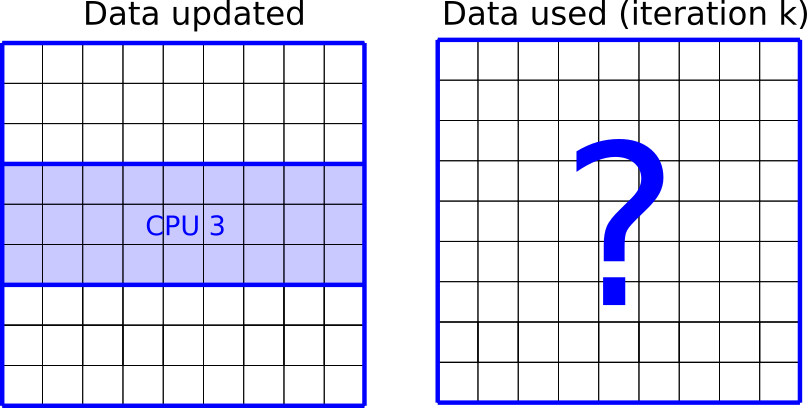
</div>
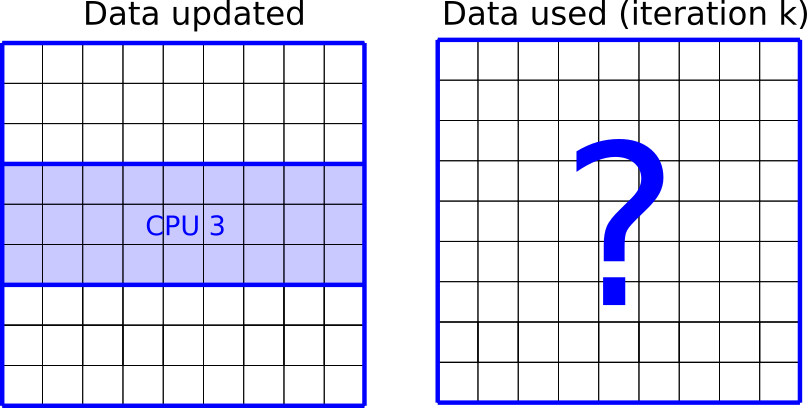

At each iteration, the processor needs the input values `C[i,j]`, `C[i,k]` and `C[k,j]`. Since we split the data row-wise, the process already has values `C[i,j]` and `C[i,k]`. However, `C[k,j]` may be stored in a different process. 

<div>
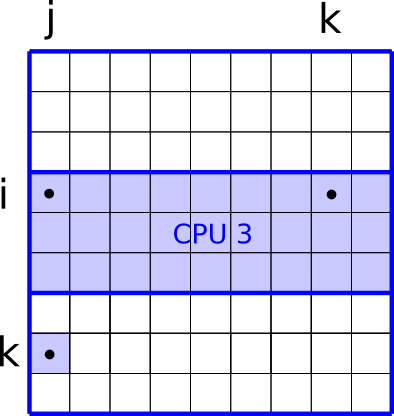
</div>
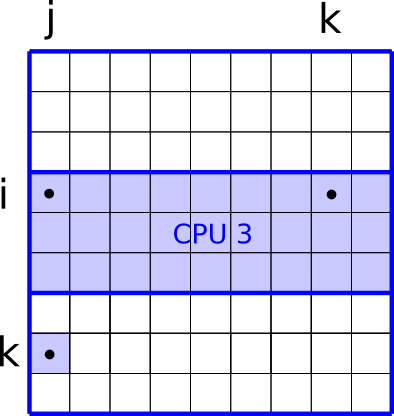

As we iterate over columns $j$, the process needs input from all values of row $k$. Therefore, at the start of iteration $k$, the whole row $k$ needs to be communicated.

<div>
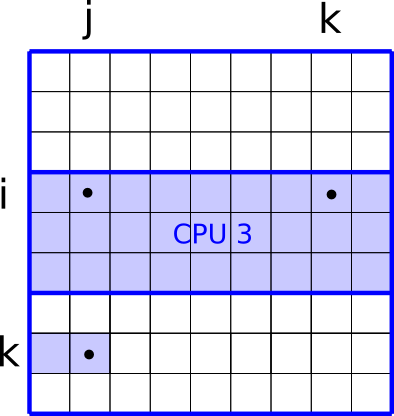
</div>
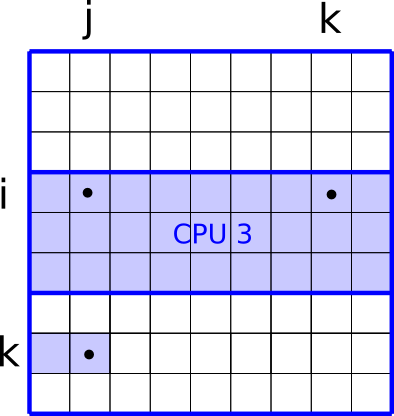

In summary, at iteration $k$ a given process will need row number $k$ which might be stored remotely in another process. The owner of row $k$ needs to *broadcast* this row to the other processes at iteration $k$.

<div>
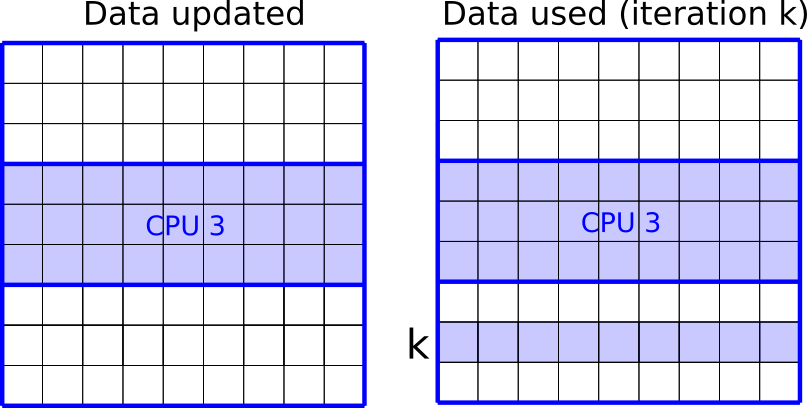
</div>
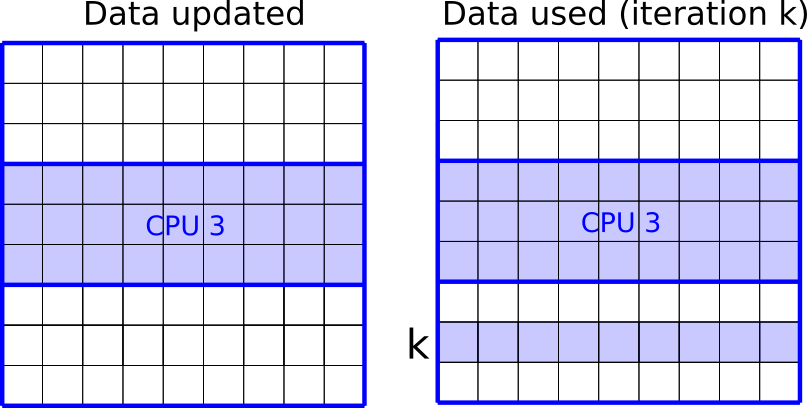

### Efficiency

- Each process updates $N^2/P$ entries per iteration
- 1 process broadcasts a message of length $N$ to $P-1$ processes per iteration
- The send cost in this process is $O(N P)$ per iteration (if we use send/receive instead of broadcast)
- $P-1$ processes receive one message of length $N$ per iteration
- The receive cost is $O(N)$ per iteration at each process
- The send/computation ratio is $O(P^2/N)$
- The receive/computation ratio is $O(P/N)$
- The algorithm is potentially scalable if $P<<N$

<div>
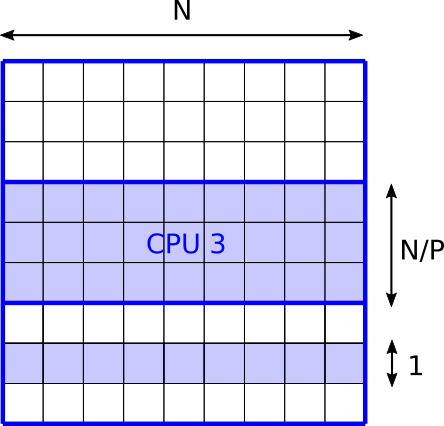
</div>
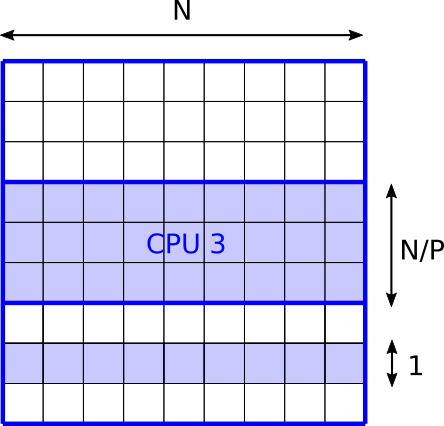

## Parallel Implementation


### Creating MPI workers

In [ ]:
] add MPI, MPIClusterManagers

In [ ]:
using MPIClusterManagers
using Distributed
if procs() == workers()
    nranks = 3
    manager = MPIWorkerManager(nranks)
    addprocs(manager)
    @everywhere using MPI; MPI.Init()
end

### Code

We split the code in two functions. The first function is called on the main process (the process running this notebook). It splits the input matrix into blocks of rows. Then, we call `floyd_worker!` (see below) remotely on each worker using the corresponding block of rows.


In [ ]:
function floyd_dist!(C)
    m = size(C,1)
    @assert mod(m,nworkers()) == 0
    nrows_w = div(m,nworkers())
    @sync for (i,w) in enumerate(workers())
        rows_w = (1:nrows_w) .+ (i-1)*nrows_w
        Cw = C[rows_w,:]
        @async C[rows_w,:] = remotecall_fetch(floyd_worker!,w,Cw,rows_w)
    end
    C
end

The second function is the one run on the workers. Note that we considered MPI for communication in this case.

In [ ]:
@everywhere function floyd_worker!(Cw,rows_w)
    comm = MPI.Comm_dup(MPI.COMM_WORLD)
    rank = MPI.Comm_rank(comm)
    nranks = MPI.Comm_size(comm)
    m,n = size(Cw)
    C_k = similar(Cw,n)
    for k in 1:n
        if k in rows_w
            myk = (k-first(rows_w))+1
            C_k .= view(Cw,myk,:)
            for proc in 0:(nranks-1)
                if rank == proc
                    continue
                end
                MPI.Send(C_k,comm;dest=proc,tag=0)
            end
        else
            MPI.Recv!(C_k,comm,source=MPI.ANY_SOURCE,tag=0)
        end
        for j in 1:n
            for i in 1:m
                @inbounds Cw[i,j] = min(Cw[i,j],Cw[i,k]+C_k[j])
            end
        end
    end
    Cw
end

### Testing the implementation

In [ ]:
function rand_distance_table(n)
  threshold = 0.4
  mincost = 3
  maxcost = 10
  infinity = 10000*maxcost
  C = fill(infinity,n,n)
  for j in 1:n
    for i in 1:n
      if rand() > threshold
        C[i,j] = rand(mincost:maxcost)
      end
    end
    C[j,j] = 0
  end
  C
end

In [ ]:
using Test
load = 10
n = nworkers()*load
C = rand_distance_table(n)
C_seq = floyd!(copy(C))
C_par = floyd_dist!(copy(C))
@test C_seq == C_par

### Is this implementation correct?

- Point-to-point messages are *non-overtaking* (i.e. FIFO order) according to section 3.5 of the MPI standard 4.0

- Unfortunately this is not enough in this case

If we are lucky all messages will arrive in order and we will process all rows in the right order in all processors.

<div>
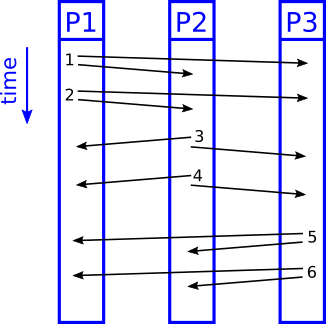
</div>
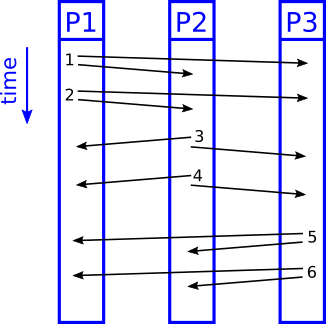

However, FIFO ordering is not enough. In the next figure communication between process 1 and process 3 is particularly slow. Note that process 3 receives messages from process 1 after the messages received from 2 even though FIFO order is satisfied between any two processors.

<div>
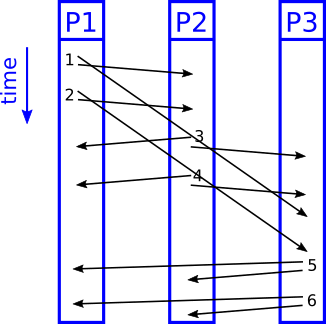
</div>
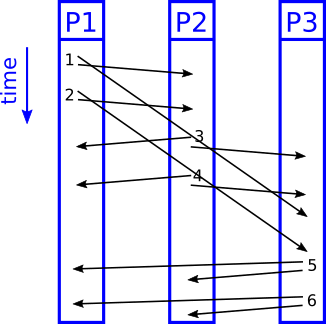

### Possible solutions

- Use synchronous send MPI_SSEND (less efficient). Note that the blocking send MPI_SEND used above does not guarantee that the message was received.
- Barrier at the end of each iteration over $k$ (simple solution, but synchronization overhead)
- Order incoming messages (buffering and extra user code needed)
- Use a specific rank id instead of `MPI.ANY_SOURCE` or use `MPI.Bcast!` (one needs to know which are the rows owned by the other ranks)

# License



This notebook is part of the course [Programming Large Scale Parallel Systems](https://www.francescverdugo.com/XM_40017) at Vrije Universiteit Amsterdam and may be used under a [CC BY 4.0](https://creativecommons.org/licenses/by/4.0/) license.